## Перечень токов воловсковой клетки
A) волосковая клетка
1) K_a (активация и инактивация) // 3 (акт) + 1 (инакт) ворот (клетка 2 типа)
2) K_dr (только активация) // 2 (акт) ворот (клетка 2 типа)
3) K_low (в клетках 1 типа у голберга про черепаху) // 3(? не отличается от 5) (акт) (E=-80) -- есть доклад с числами (клетка 1 типа)-- итог: 2 ворот, 3 состояния
    экспериментальные данные приведены в "I-K-Low-investig"
5) K_iv_rect (для клеток 2 типа) (?)
   


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import lambertw
from scipy.optimize import curve_fit

Порядок исследования:

1) результаты воль-клампа: конечные значения тока – $P_{open}(V_{test})$ ($m$ - в нашей интерпритации)
2) результаты воль-клампа: сами траектории ($I(t)$) аппроксимируются решениями уравнениями Колмогорова // возможен промежуточный шаг: аппроксимация больцманом для гладкости и минимизации ошибок или для оценки реузльтатов приведенных в статьях. Таким образом получаем $\tau$
3) Создание вычислительного вольт-клампа

In [2]:
def acc_alpha_beta(V: np.array, V_test: np.array, a0, b0, m: np.array, tau: np.array):
    # Delta calculations
    u_alpha1 = a0[1] * V + b0[1]
    u_beta1 = a0[0] * V + b0[0]
    alpha1 = u_alpha1 / (1 - np.exp(-u_alpha1))
    beta1 = np.exp(-u_beta1)
    dbeta1 = -np.exp(-u_beta1)
    dalpha1 = (1 - np.exp(-u_alpha1) - u_alpha1 * np.exp(-u_alpha1)) / (1 - np.exp(-u_alpha1)) ** 2
    Delta_beta = np.sqrt(np.sum((beta - beta1) ** 2 / np.abs(dbeta1))) / len(beta)
    Delta_alpha = np.sqrt(np.sum((alpha - alpha1) ** 2 / np.abs(dalpha1))) / len(alpha)
    Delta_m = np.sqrt(np.sum((m - alpha1 / (beta1 + alpha1)) ** 2)) / len(m)
    Delta_tau = np.sqrt(np.sum((np.array(tau) - 1 / (beta1 + alpha1)) ** 2)) / len(tau)
    return Delta_alpha, Delta_beta, Delta_m, Delta_tau    
    # Test
def test_alpha_beta(V: np.array, V_test: np.array, a0, b0, m: np.array, tau: np.array, mkoef=10):

    u_alpha = a0[1] * V_test + b0[1]
    u_beta = a0[0] * V_test + b0[0]    
    alpha_test = u_alpha / (1 - np.exp(-u_alpha))
    beta_test = np.exp(-u_beta)

    m_test = alpha_test / (beta_test + alpha_test)
    tau_test = 1 / (beta_test + alpha_test)
    
    plt.figure(1)
    plt.plot(V_test, beta_test, linewidth=2)
    plt.plot(V_test, alpha_test, linewidth=2)
    plt.plot(V, beta, '<b', linewidth=2, markersize=4)
    plt.plot(V, alpha, '>r', linewidth=2, markersize=4)
    plt.legend(['$\\beta$', '$\\alpha$', '$\\beta_e$', '$\\alpha_e$'], loc='upper right')
    plt.title(title_m_tau)
    plt.xlabel('V, mV')
   
    plt.figure(2)
    plt.plot(V_test, m_test, 'b', linewidth=2)
    plt.plot(V_test, tau_test / mkoef, 'r', linewidth=2)
    plt.plot(V, m, '<b', linewidth=2, markersize=4)
    plt.plot(V, np.array(tau) / mkoef, '>r', linewidth=2, markersize=4)
    plt.legend(['$m \\times 1$', '$\\tau$', '$m_e \\times 1$', '$\\tau_e$'], loc='upper left')
    plt.title(title_m_tau)
    plt.xlabel('V, mV')
    plt.show()
    return alpha_test, beta_test, m_test, tau_test

## Волосковая клетка: ток Ка, инактивация

In [3]:
# Parameters for vestibular sensory cell. Published in Biophysics 2023.
title_m_tau = 'Ka inact'
m_Ka_in   = [0.9924, 0.99016, 0.9774, 0.13166, 0.0344, 0.0027]
V_m_Ka_in = [-120,      -110,   -100,     -80,    -70,    -60]
tau_Ka_in =   [175.6, 397.27, 137.52, 92.8]
V_tau_Ka_in = [-100, -80, -70, -60]

In [4]:
#поиск параметров функции больцмана для вероятности. Большее сглаживание улучшает сходимость задачи
def find_Boltsman_from_exp_data(m_: np.array, V_m_: np.array):
    # Calculation of parameters
    M_boltsman = np.vstack((-np.log((np.ones(len(m_)) - m_) / m_), np.ones(len(m_)))).T
    x = np.linalg.inv(M_boltsman.T @ M_boltsman)@ M_boltsman.T@ np.array(V_m_)
    V0 = x[1]
    s = x[0]
    return V0, s

In [5]:
# функция поиска квазилинейно замены. Альфа и бета должны быть заданы массивами
def find_aa_bb_by_mnk(alpha_: np.array, beta_: np.array, V_: np.array):
    # Inverse functions
    u = np.zeros((2, len(alpha_)))  # Initialize u
    u[0,:] = -np.log(beta_)
    argFun = -alpha_ * np.exp(-alpha_)  # Argument for Lambert W function
    u[1,:] = alpha_ + lambertw(argFun, k=1).real 
    # MNK (Method of Least Squares)
    x = np.array(V_)
    a0 = np.zeros(2)
    b0 = np.zeros(2)
    for i in range(2):
        y = u[i]
        E_xy = np.mean(x * y)
        E_xx = np.mean(x ** 2)
        E_x = np.mean(x)
        E_y = np.mean(y)

        covXY = E_xy - E_x * E_y
        covXX = E_xx - E_x * E_x

        a0[i] = covXY / covXX
        b0[i] = E_y - a0[i] * E_x
    return a0, b0

### параметры аппроксимации экспериментальных данных

In [6]:
m_exp =  np.array(m_Ka_in)
V_m_exp= np.array(V_m_Ka_in)
tau    = np.array(tau_Ka_in)
V_tau =  np.array(V_tau_Ka_in)
V0, s=find_Boltsman_from_exp_data(m_exp, V_m_exp)
m = 1 / (1 + np.exp(-(np.array(V_tau) - V0) / s))
# Formulas
alpha = m / np.array(tau)
beta = (1 - m) / np.array(tau)

### расчет для квазилинейного аргумента

In [7]:
a0, b0=find_aa_bb_by_mnk(alpha, beta, V_tau)

In [8]:
a0, b0

(array([-0.08035675, -0.12845768]), array([ -0.41270864, -20.45030856]))

### Test

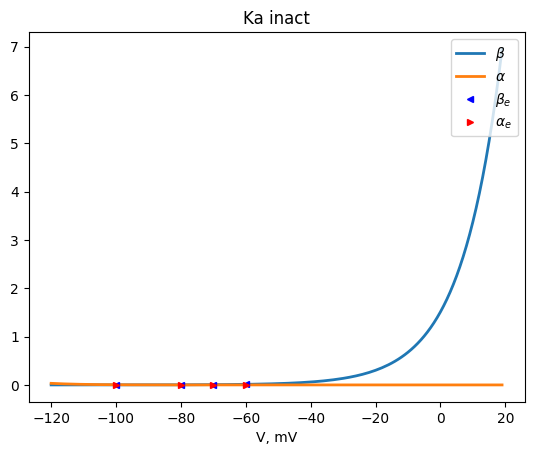

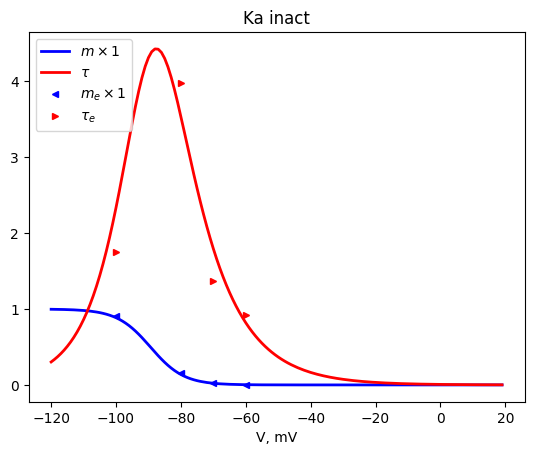

In [8]:
V_test=np.arange(-120, 20,1)
Delta_alpha, Delta_beta, Delta_m,Delta_tau = acc_alpha_beta(V_tau, V_test, a0, b0, m, tau)
alpha_rez, beta_rez, m_rez, tau_rez = test_alpha_beta(V_tau, V_test, a0, b0, m, tau, mkoef=100)

В экспериментах VoltClamp термин "Q10" обычно относится к температурному коэффициенту процесса, указывающему, насколько меняется скорость этого процесса при изменении температуры на 10°C. Он вычисляется как отношение параметра (например, проводимости, временной константы) при одной температуре к тому же параметру при температуре, выше на 10°C.

Например, если параметр (например, проводимость) удваивается при увеличении температуры на 10°C, значение Q10 будет равно 2. Если параметр остается неизменным при увеличении температуры на 10°C, значение Q10 будет равно 1.

Таким образом, в контексте эксперимента по вольтаж-клеммированию, если вы видите сообщенное значение Q10, это указывает, насколько изменяется определенный аспект эксперимента (например, проводимость или кинетика) при изменении температуры на 10°C.

Q10 ввели ХХ в одной из работ 1952 года. Надо ее найти

## интенсивности токов клетки
для вычислений использованы функции выше

### $K_{Low}$

по статье A Delayed Rectifier Conductance in Type I Hair Cells of the Mouse Utricle

только для клеток I типа

## температура 23-25$^{\circ}C$

$g_{max}=75 \pm 65 \mathrm{nS}$ at $-54 \mathrm{mV}$

In [9]:
# равновестный потенциал
E_K=-71 
# максимальная проводимость при температуре 23 градуса С
gmax=75 # nS
g=gmax
# значения потенциалов (тестовых)
V_K_Low_exp=np.array([-80,-69, -61, -53, -45, -36, -30, -20])
# максимальные значения токов
I_K_low_exp=np.array([0.2, 0.6, 1.4, 2.6, 3.79997435, 3.8, 3.8, 4])

T=23
T0=23
#V12=-74 # соответсвие max tau
V12=-74+(T-T0)*0.8 #V12=-67 #(-88 – -62)
#V12=-74 # соответсвие max tau
# вероятность в соответсвии с гипотезой 2х ворот
s=5.1
m_K_Low_exp=np.sqrt(np.abs(1/(1+np.exp((V12-V_K_Low_exp)/s))))
print('m_K_Low_exp=',m_K_Low_exp)

# меньшая постоянная времени
tau_K_Low_exp=np.array([13.34501086, 22.29571298, 12.75095376, 9.56627526, 7.45838437, 8.72415482, 8.07433331, 7.13004562])
print('tau_K_Low_exp=',tau_K_Low_exp)

m_K_Low_exp= [0.48547645 0.85275203 0.96307197 0.9919567  0.9983082  0.99970969
 0.99991045 0.99998739]
tau_K_Low_exp= [13.34501086 22.29571298 12.75095376  9.56627526  7.45838437  8.72415482
  8.07433331  7.13004562]


In [10]:
tau    = np.array(tau_K_Low_exp)
V_exp =  np.array(V_K_Low_exp)
m = np.array(m_K_Low_exp)# np.sqrt(1/(1+np.exp((V12-V_exp)/s)))
# Formulas
alpha = m / np.array(tau)
beta = (1 - m) / np.array(tau)
#plt.figure(1)
#plt.plot(V_exp, alpha, 'r*')
#plt.figure(2)
#plt.plot(V_exp, beta, 'b*')
title_m_tau = 'K Low'

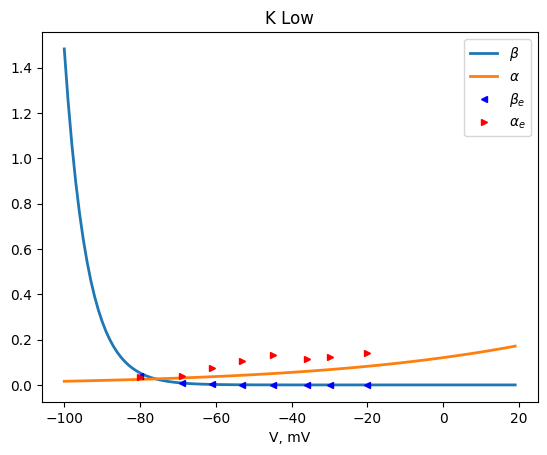

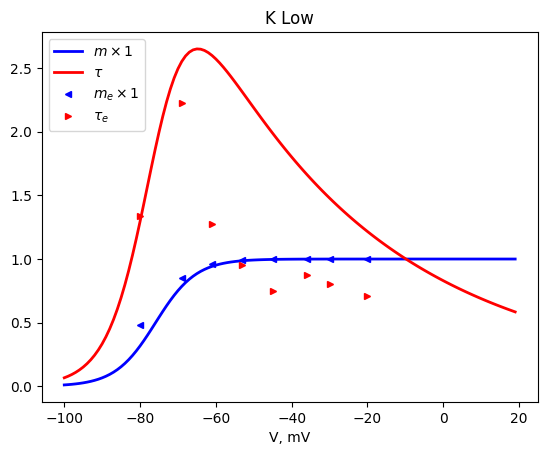

In [11]:
a0, b0=find_aa_bb_by_mnk(alpha, beta, V_exp)
V_test=np.arange(-100, 20,1)
Delta_alpha, Delta_beta, Delta_m,Delta_tau = acc_alpha_beta(V_exp, V_test, a0, b0, m, tau)
alpha23, beta23, m23, tau23= test_alpha_beta(V_exp, V_test, a0, b0, m, tau, mkoef=10)

## температура 33-36$^{\circ}C$

$g_{max}=117 \mathrm{nS}$ 

In [12]:
# равновестный потенциал
E_K=-71 
# максимальная проводимость при температуре 23 градуса С
gmax=117 # nS
g=gmax
# значения потенциалов (тестовых)
V_K_Low_exp=np.array([-80,-69, -61, -53, -45, -36, -20])
# максимальные значения токов
I_K_low_exp=np.array([0.005, 0.4 , 1.5  , 2.9  , 4.8  , 3.5  , 5.   ])

T=36
T0=23
#V12=-74 # соответсвие max tau
V12=-74+(T-T0)*0.8 #V12=-67 #(-88 – -62)

# вероятность в соответсвии с гипотезой 2х ворот
m_K_Low_exp=np.sqrt(np.abs(1/(1+np.exp((V12-V_K_Low_exp)/s))))
# меньшая постоянная времени
tau_K_Low_exp=np.array([14.0590281, 14.3938288, 26.3377299, 16.11779519, 10.96745138 ,9.9026012,  7.77559511])

In [13]:
tau    = np.array(tau_K_Low_exp)
V_exp =  np.array(V_K_Low_exp)
m = np.array(m_K_Low_exp)# np.sqrt(1/(1+np.exp((V12-V_exp)/s)))
# Formulas
alpha = m / np.array(tau)
beta = (1 - m) / np.array(tau)
#plt.figure(1)
#plt.plot(V_exp, alpha, 'r*')
#plt.figure(2)
#plt.plot(V_exp, beta, 'b*')

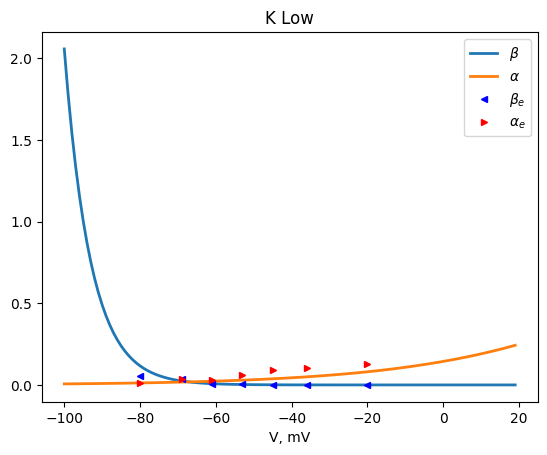

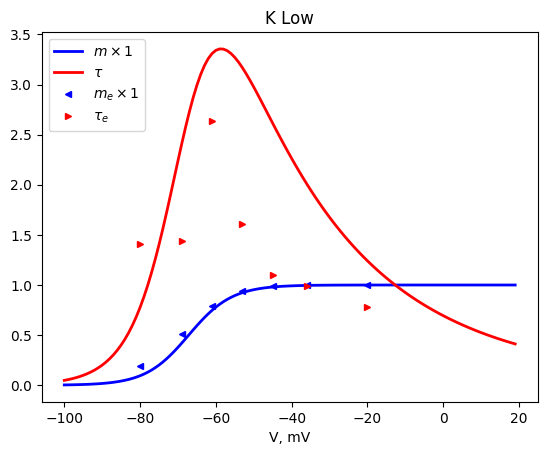

In [14]:
a0, b0=find_aa_bb_by_mnk(alpha, beta, V_exp)
#V_test=np.arange(-100, -20,1)
Delta_alpha, Delta_beta, Delta_m,Delta_tau = acc_alpha_beta(V_exp, V_test, a0, b0, m, tau)
alpha36, beta36, m36, tau36 = test_alpha_beta(V_exp, V_test, a0, b0, m, tau, mkoef=10)

In [15]:
#plt.plot(V_test, m23, 'b', linewidth=2)
#plt.plot(V_test, m36, 'r', linewidth=2)

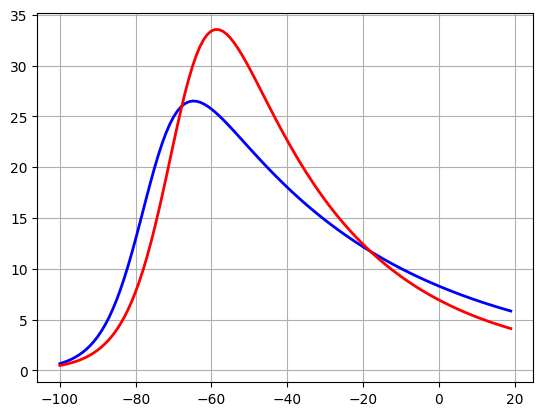

In [16]:
plt.plot(V_test, tau23, 'b', linewidth=2)
plt.plot(V_test, tau36, 'r', linewidth=2)
plt.grid(visible=True)

(-0.01, 0.1)

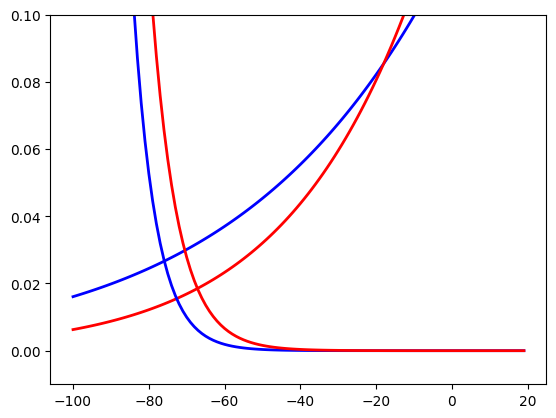

In [17]:
V_test=np.arange(-100, 20,1)
plt.plot(V_test, alpha23, 'b', linewidth=2)
plt.plot(V_test, alpha36, 'r', linewidth=2)
plt.plot(V_test, beta23, 'b', linewidth=2)
plt.plot(V_test, beta36, 'r', linewidth=2)
plt.ylim([-0.01, 0.1])

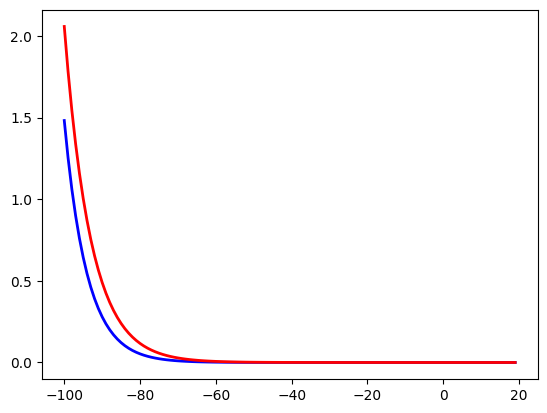

In [18]:
plt.plot(V_test, beta23, 'b', linewidth=2)
plt.plot(V_test, beta36, 'r', linewidth=2)

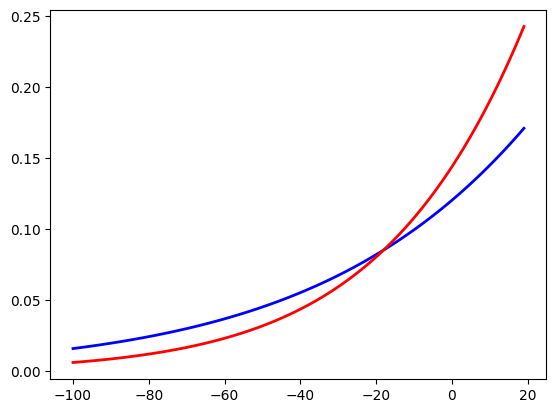

In [19]:
plt.plot(V_test, alpha23, 'b', linewidth=2)
plt.plot(V_test, alpha36, 'r', linewidth=2)

## Волосковая клетка: ток Ка, активация

In [20]:
# Параметры для сенсорной клетки. Вестибулярной. результаты опубликованы в Биофизике 2023
# catacuzzeno by KA
#-----Ka_active--------------------------
# input values K_a % 3 частицы
title_m_tau='Ka act'
V_m_Ka_a = [-70, -65, -60, -50, -40, -35] # %, -25 , 0 %
V_tau_Ka_a=[-70, -65, -60, -50, -40, -35] #%, -25 , 0 %
tau_Ka_a = [2.63, 3.2, 3.69, 4.2, 4.0, 3.4]# %, 3.13 , 1.86
m_Ka_a=[0.016, 0.044, 0.102, 0.33, 0.61, 0.78]# %, 0.87, 0.99 0.87 (7 number) -???

In [21]:
m_exp =  np.array(m_Ka_a)
V_m_exp= np.array(V_m_Ka_a)
tau    = np.array(tau_Ka_a)
V_tau =  np.array(V_tau_Ka_a)
V0, s=find_Boltsman_from_exp_data(m_exp, V_m_exp)
m = 1 / (1 + np.exp(-(np.array(V_tau) - V0) / s))
# Formulas
alpha = m / np.array(tau)
beta = (1 - m) / np.array(tau)

In [22]:
a0, b0=find_aa_bb_by_mnk(alpha, beta, V_tau)

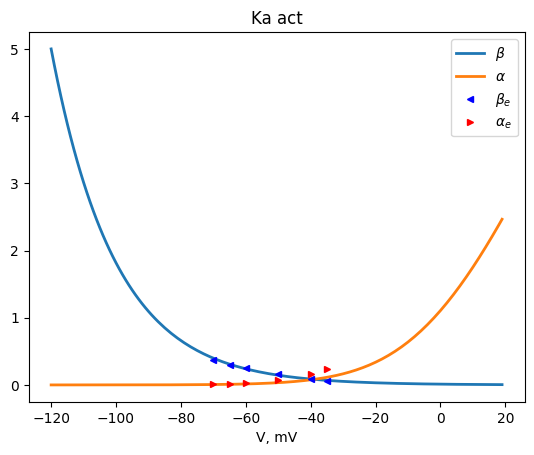

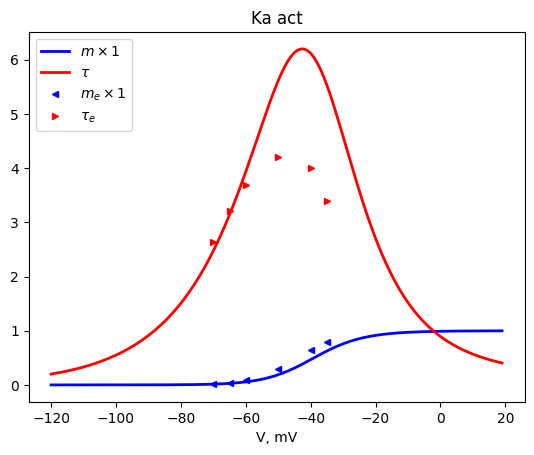

In [23]:
V_test=np.arange(-120, 20,1)
Delta_alpha, Delta_beta, Delta_m,Delta_tau = acc_alpha_beta(V_tau, V_test, a0, b0, m, tau)
alpha, beta, m_rez, tau_rez = test_alpha_beta(V_tau, V_test, a0, b0, m, tau, mkoef=1)

### Волосковая клетка: ток Кdr

In [24]:
# Параметры для сенсорной клетки. Вестибулярной. результаты опубликованы в Биофизике 2023
# catacuzzeno by KA
# 2 частицы
#------Kdr---------------------
title_m_tau='Kdr'
V_m_Kdr = [-70, -60, -50, -40, -30, -20, -10]# %,, 0, 10
V_tau_Kdr=V_m_Kdr
tau_Kdr = [15, 18, 15.6, 14, 10, 7.6, 5.8]# , 1.96, 4.12 %, 3
m_Kdr=[0.175, 0.415, 0.697, 0.817, 0.91, 0.943, 0.97]# %,0.990.99,, 1%%

In [25]:
m_exp =  np.array(m_Ka_a)
V_m_exp= np.array(V_m_Ka_a)
tau    = np.array(tau_Ka_a)
V_tau =  np.array(V_tau_Ka_a)
V0, s=find_Boltsman_from_exp_data(m_exp, V_m_exp)
m = 1 / (1 + np.exp(-(np.array(V_tau) - V0) / s))
# Formulas
alpha = m / np.array(tau)
beta = (1 - m) / np.array(tau)

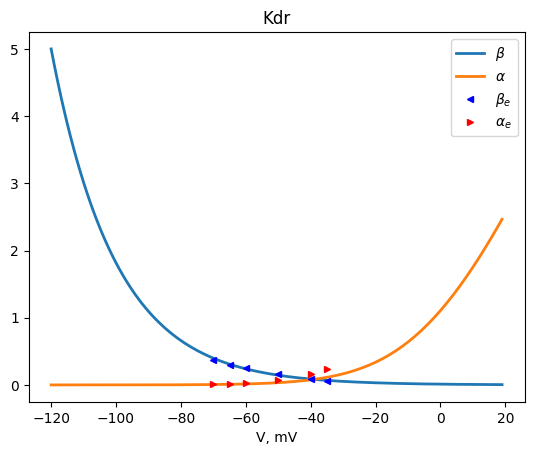

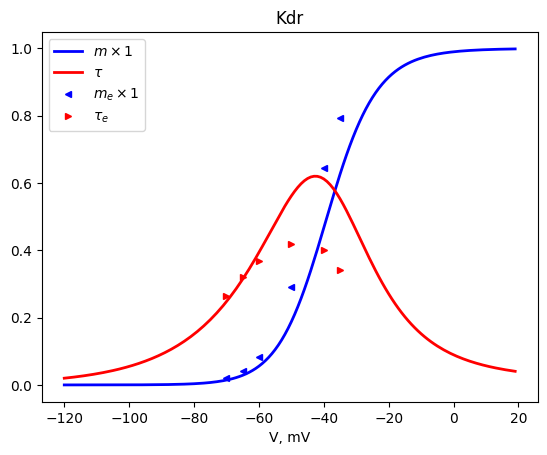

In [26]:
a0, b0=find_aa_bb_by_mnk(alpha, beta, V_tau)
V_test=np.arange(-120, 20,1)
Delta_alpha, Delta_beta, Delta_m,Delta_tau = acc_alpha_beta(V_tau, V_test, a0, b0, m, tau)
alpha, beta, m, tau = test_alpha_beta(V_tau, V_test, a0, b0, m, tau)

## Динамика тока в вестибулярной клекте  I типа

каливый ток с неквантовой составляющей

In [27]:
def alpha_beta_K_Low(V_):
    a0, b0=[0.10526733, 0.03401875], [11.00262901, -3.32346959]
    u_alpha = a0[1] * V_ + b0[1]
    u_beta = a0[0] * V_ + b0[0]    
    alpha_ = u_alpha / (1 - np.exp(-u_alpha))
    beta_ = np.exp(-u_beta)
    return alpha_, beta_

In [28]:
def K_low_HC_typeI_P_C(t, y, V, G_K=10, RTF=25, C_HC_cl=140):
    # учтено изменение концентрации в щели
    # x1 x2 x3 вероятности состояний x3 -- Open
    x1,x2, x3, C_K_cl = y
    alpha, beta = alpha_beta_K_Low(V)
    dx1= - 2 * alpha*x1 + beta*x2
    dx2= -(alpha+beta)*x2 + 2*alpha*x1 + 2*beta*x3
    dx3= alpha*x2 - 2 * beta * x3
    E_K_cl=RTF * np.log(C_K_cl/C_HC_cl)
    dC_K_cl=G_K*x3*(V-E_K_cl) #I_K_Low
    return dx1, dx2, dx3, dC_K_cl

In [29]:
RTF=25 # RT/F -- постоянная
C_HC_cl=140 # мМоль --- концентрация калия в волосковой клетке
G_K=75 #нСим
#I_K_Low=G_K*P_Open*(V-E_K_cl)
#E_K_cl=RTF * np.log(C_K_cl/C_HC_cl) # равновесный потенциал калия dC_K^{cleft}/dt =I_{K_{Low}}.
T0=0
T1=100
V=-50
args = (V, G_K, RTF, C_HC_cl, )
y0=[0.3, 0.2, 0.5, 28]#[P_1_st, P_2_st, 1-P_1_st-P_2_st] #[0,0]#
sol = scipy.integrate.solve_ivp(fun=K_low_HC_typeI_P_C, t_span=[T0, T1], y0=y0, method='BDF', args=args)

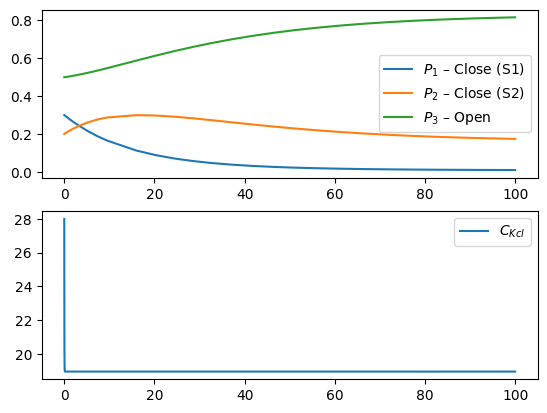

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(sol.t, sol.y[0,:], label='$P_1$ – Close (S1)')
ax1.plot(sol.t, sol.y[1,:], label='$P_2$ – Close (S2)')
ax1.plot(sol.t, sol.y[2,:], label='$P_3$ – Open')
#ax1.title('Вероятности при V='+ str(V)+', начальные условия: '+str(y0))
ax1.legend()

#ax2.plot(sol.t, sol.y[3,:], label='${E_K}_{cl}$')
#ax2.plot(sol.t, sol.y[4,:], label='${I_K}_{Low}$')
ax2.plot(sol.t, sol.y[3,:], label='${C_K}_{cl}$')
#plt.title('Вероятности при V='+ str(V)+', начальные условия: '+str(y0))
plt.legend()

# Volt-Clamp

In [31]:
g_tr=0.182 #nS при неподвижных стериоцилиях
E_tr=0
G_K=75
RTF=25
C_HC_cl=140
G_leak=2
E_leak=0

In [32]:
def E_K_cl_fun(C_K_cl, C_HC_cl=140, RTF=25):
    return RTF * np.log(C_K_cl/C_HC_cl)

In [33]:
# вклюдчает K_low_HC_typeI_P_C
def HC_I_type(t, y, Cm=10, g_tr=0.182, E_tr=0, G_K=75, RTF=25, C_HC_cl=140, G_leak=0, E_leak=0): #Cm [nS],  G_leak [nS], E_leak[mV]
    V, x1,x2, x3, C_K_cl = y
    # I_K_Low с постоянной проводимостью
    alpha, beta = alpha_beta_K_Low(V)
    dx1= -2 * alpha*x1 + beta*x2
    dx2= -(alpha+beta)*x2 + 2*alpha*(1-x2-x3) +2*beta*x3
    dx3= alpha*x2 - 2* beta * x3 # вероятность открытия калиевого канала
    E_K_cl=E_K_cl_fun(C_K_cl, C_HC_cl, RTF)
    dC_K_cl=G_K*x3*(V-E_K_cl) #I_K_Low

    # уравнение волосковой клетки
    dV= -1/Cm * (g_tr*(V-E_tr) + G_K * x3 * (V-E_K_cl)+ G_leak * (V-E_leak))
    return dV, dx1, dx2, dx3, dC_K_cl

In [34]:
# вклюдчает K_low_HC_typeI_P_C
def HC_I_type_VC(t, y, Cm=10, g_tr=0, E_tr=0, G_K=75, RTF=25, C_HC_cl=140, G_leak=2, E_leak=0, VoltClamp=0): #Cm [pF],  G_leak [nS], E_leak[mV]
    V, x1,x2, x3, C_K_cl = y
    # I_K_Low с постоянной проводимостью
    alpha, beta = alpha_beta_K_Low(V)
    #if x1+x2+x3 >1:
    #    print('включи условие нормировки')
    #    print(x1+x2+x3)
    dx1= -2 * alpha*x1 + beta*x2
    dx2= -(alpha+beta)*x2 + 2*alpha*(1-x2-x3) +2*beta*x3
    dx3= alpha*x2 - 2* beta * x3 # вероятность открытия калиевого канала
    E_K_cl=-79# E_K_cl_fun(C_K_cl, C_HC_cl, RTF)
    dC_K_cl=0#G_K*x3*(V-E_K_cl) #I_K_Low

    # уравнение волосковой клетки
    dV= -1/Cm * (g_tr*(V-E_tr) + G_K * x3 * (V-E_K_cl)+ G_leak * (V-E_leak))
    if VoltClamp==1:
    # для Volt-Clamp
        dV= 0
    return dV, dx1, dx2, dx3, dC_K_cl

$G_K = max (g_K)=(I(-20)-I(-36))/(-20-(-36))$ из предположения $m(-20) \approx m(-36) \approx 1$

In [35]:
# набор параметров одобрен НВК
Cm=10 # для I типа, 2 для II типа
g_tr=0.182
E_tr=0
G_K=75 ## nS
RTF=25
C_HC_cl=140
G_leak=1
E_leak=0

In [36]:
T0=0
T1=100
V=20
VoltClam=0
args = (Cm, g_tr, E_tr, G_K, RTF, C_HC_cl, G_leak, E_leak)
y0=[V, 0.1,0.1, 0.1, 100]#[P_1_st, P_2_st, 1-P_1_st-P_2_st] #[0,0]#
sol = scipy.integrate.solve_ivp(fun=HC_I_type, t_span=[T0, T1], y0=y0, method='BDF', args=args)
C_K_cl=sol.y[4,-1]
E_K=-79 # E_K_cl_fun(C_K_cl, C_HC_cl, RTF)
V_rest=(g_tr*E_tr+G_K*sol.y[3, -1]*E_K +
        G_leak*E_leak)/(g_tr+G_K*sol.y[3, -1]+G_leak)
y0=sol.y[:, -1]
print(y0)

[5.53074961e-03 1.86351811e-08 2.71832091e-04 9.99728148e-01
 1.40031152e+02]


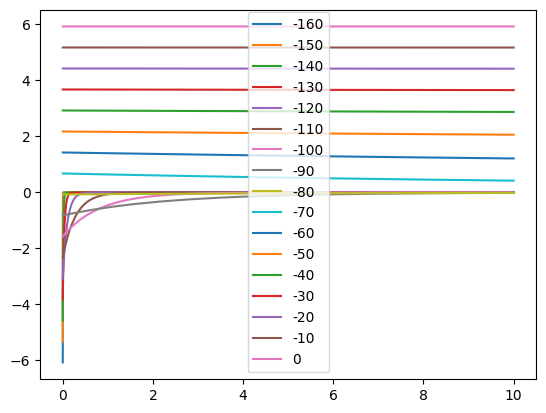

In [37]:
T1=10
VoltClam=1
for V in np.arange(-160, 3, 10):
    y0[0]=V
    args = (Cm, g_tr, E_tr, G_K, RTF, C_HC_cl, G_leak, E_leak, VoltClam)
    sol = scipy.integrate.solve_ivp(fun=HC_I_type_VC, t_span=[T0, T1], y0=y0, method='BDF', args=args)
    E_K=-79
    plt.plot(sol.t, sol.y[3,:]*G_K*(V-E_K)*10**(-3), label=str(V)) # 10**(-3) связано производной в мс
plt.legend()

/var/folders/71/8yb_lvl54pz8dp2_bbz_8zcc0000gn/T/ipykernel_21720/3899616779.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


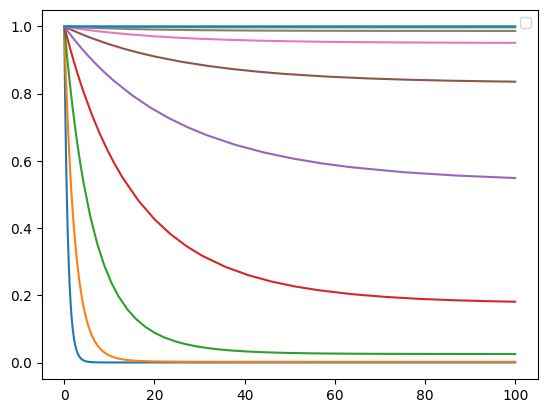

In [38]:
T1=100
VoltClam=1
for V in np.arange(-100, 3, 10):
    y0[0]=V
    args = (Cm, g_tr, E_tr, G_K, RTF, C_HC_cl, G_leak, E_leak, VoltClam)
    sol = scipy.integrate.solve_ivp(fun=HC_I_type_VC, t_span=[T0, T1], y0=y0, method='BDF', args=args)
    E_K=-79
    plt.plot(sol.t, sol.y[3,:])
plt.legend()

## Динамика тока в вестибулярной клекте  II типа

каливый ток с неквантовой составляющей

In [39]:
def alpha_beta_K_dr(V):
    #(a_α;b_α)=(0.0628; -2.163) (a_β;b_β)=(0.0872 ; 9.16)
    aa=0.0628
    ba=-2.163
    ab=0.0872
    bb=9.16
    ua=aa*V+ba
    ub=ab*V+bb
    alpha=ua/(1-np.exp(-ua))
    beta=np.exp(-ub)
    return alpha, beta
    

def alpha_beta_Ka_a(V):
    #(a_α;b_α)=(0.0492; 0.0111)(a_β;b_β)=(4.383; 1.1439)
    aa=0.1259
    ba=2.0582
    ab=0.0506
    bb=4.4644
    ua=aa*V+ba
    ub=ab*V+bb
    alpha=ua/(1-np.exp(-ua))
    beta=np.exp(-ub)
    return alpha, beta

def alpha_beta_Ka_in(V):
    #(a_α;b_α)=(-0.0718,-0.1797)(a_β;b_β)=(-0.2166,-23.94)
    aa=-0.13408
    ba=-20.669344
    ab=-0.080357
    bb=-0.412709
    ua=aa*V+ba
    ub=ab*V+bb
    alpha=ua/(1-np.exp(-ua))
    beta=np.exp(-ub)
    return alpha, beta

In [40]:
Vtest=np.arange(-120, -20, 2)
#расчет проводимстей
a, b = np.zeros(np.size(Vtest)), np.zeros(np.size(Vtest))
for i, v in enumerate(Vtest):
    a[i],b[i] = alpha_beta_Ka_in(v)

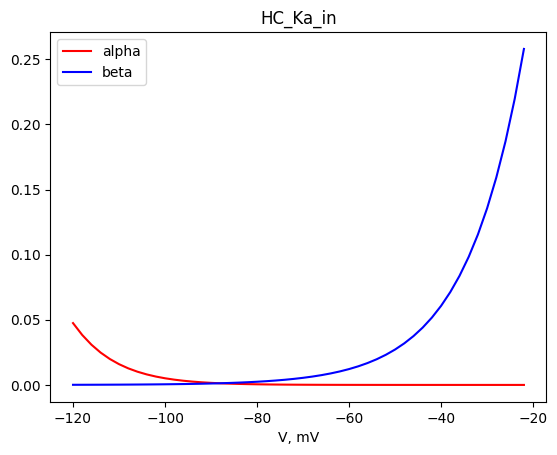

In [41]:
name='HC_Ka_in'
plt.plot(Vtest, a, 'r', label='alpha')
plt.plot(Vtest, b, 'b', label='beta')
plt.xlabel('V, mV')
plt.title(name)
plt.legend()
#plt.savefig(name+'.png')

In [42]:
#расчет проводимстей
m, tau = np.zeros(np.size(Vtest)), np.zeros(np.size(Vtest))
for i, v in enumerate(Vtest):
    m[i]=a[i]/(a[i]+b[i])
    tau[i]=1/(a[i]+b[i])

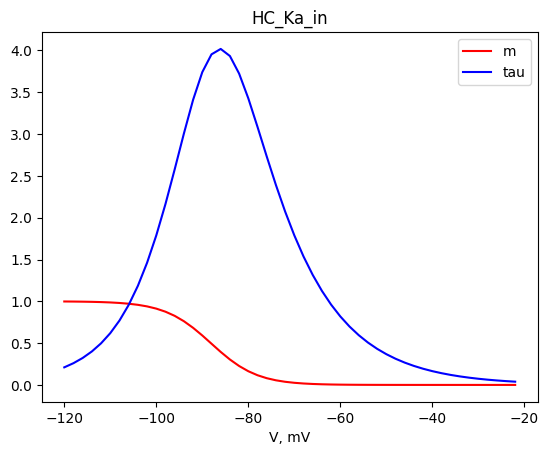

In [43]:
plt.plot(Vtest, m, 'r', label='m')
plt.plot(Vtest, tau/100, 'b', label='tau')
plt.xlabel('V, mV')
plt.title(name)
plt.legend()
#plt.savefig(name+'m_tau.png')

## Volt-Clamp
для проверки восстановленных интенсивностей с опубликованными результатами

1) на $V_{hold}$ – задаются начальные условия
2) на интервале времени интегрируется полная система вероятностей с расчетом тока: выход проверки $I(t)|_{V_{test}}$

### Фунции правых частей токов HC

1) $W$ – коэффицент разделения токов инактивации
2) второй ток инактивации (0.5*np.exp(-ti/74)+0.5)
3) $G_{name}$ – в нано сименсах, число каналов на проницаемость каналов

In [44]:
def HC_P_Ka(t, y, V):
    z1, z2, z3, z4 = y
    alpha, beta=alpha_beta_Ka_in(V)
    dz1=alpha*(1-z1)-beta*z1 # инактивация Ka
    alpha, beta =alpha_beta_Ka_a(V)
    dz2=alpha*z3-3*beta*z2 # активация Ka -- 3 порядок: Open
    dz3=2*alpha*z4-(2*beta+alpha)*z3+3*beta*z2 # S1
    dz4=(-2*alpha-beta)*z4+2*beta*z3+3*alpha*(1-z2-z3-z4) # S2
    return [dz1, dz2, dz3, dz4]

def HC_I_Ka(h, m, ti, V,W=0.5, G_Ka=5, E_K=-80):
    I=G_Ka*m*(W*h+(1-W)*(0.5*np.exp(-ti/74)+0.5))*(V-E_K)
    return I

def HC_P_Kdr(t, y, V):
    z2, z3, z4= y
    alpha, beta=alpha_beta_K_dr(V)
    dz2=alpha*z3-3*beta*z2 # активация Ka -- 3 порядок: Open
    dz3=2*alpha*z4-(2*beta+alpha)*z3+3*beta*z2 # S1
    dz4=(-2*alpha-beta)*z4+2*beta*z3+3*alpha*(1-z2-z3-z4) # S2
    return [dz2, dz3, dz4]

def HC_I_Kdr(P_open_kdr,V, G_Kdr=1, E_K=-80): #ток 2х вороткних частиц - 2 диффура
    I=G_Kdr*P_open_kdr*(V-E_K)
    pass

def HC_I_leak(V, G_leak=3, E_leak=0):
    I=G_leak*(V-E_leak)
    return I


-120 0.9979381387877585
-115 0.9945400543932976
-110 0.979955488481291
-105 0.9170701607455624
-100 0.7722376294559327
-95 0.5792760597993102
-90 0.3986704337868502
-85 0.2601340033155906
-80 0.16294749781472612
-75 0.09619542873412179
-70 0.050862876151379646
-65 0.022292912127815808
-60 0.0074608133396217215
-55 0.0019090231433605408
-50 0.0004882311379829552
-45 0.00015942860954745028
-40 5.677921282068891e-05
-35 2.028443913730167e-05
-30 7.233963145830997e-06
-25 2.5756155526812555e-06
-20 9.156576715459019e-07
-15 3.2507315396935667e-07
-10 1.1525714697759218e-07
-5 4.081612689527119e-08
0 1.443801213110498e-08
5 5.101828893091677e-09
10 1.8010075772288392e-09
15 6.35187721679947e-10
20 2.2382523072340133e-10
25 7.880574374286784e-11
30 2.7724792601993553e-11
35 3.0952092432481866e-07


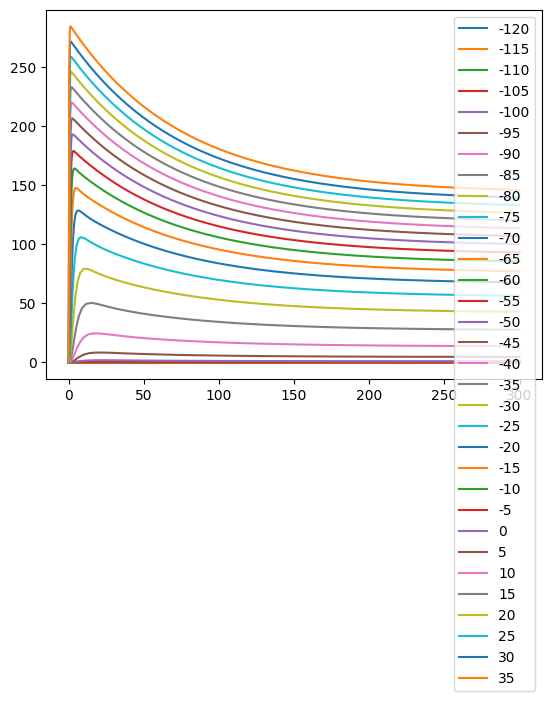

In [45]:
G_Kdr=1
T0=0
T1=1500
V_hold=-80
args = (V_hold, )
sol0 = scipy.integrate.solve_ivp(HC_P_Ka, [T0, T1], [0,0,0,0], args=args)
y0=[sol0.y[0][-1], sol0.y[1][-1], sol0.y[2][-1], sol0.y[3][-1]]
T1=300
for V_test in range(-120,40, 5):
    args = (V_test, )
    sol = scipy.integrate.solve_ivp(HC_P_Ka, [T0, T1], y0, args=args)
    print(V_test, sol.y[0][-1])
    I=np.zeros(np.size(sol.t))
    for i, t in enumerate(sol.t):
        #I[i]=G_Kdr*sol.y[0][i]*(V_test-E_K) #HC_I_Kdr(sol.y[0][i], V_test)
        I[i]=HC_I_Ka(sol.y[0][i], sol.y[1][i], t, V_test)
    plt.plot(sol.t[:], I[:], label=str(V_test))
    #print(V_test, I[-1])
plt.legend()